In [2]:
%matplotlib inline
import os
import numpy as np
import glob
import xarray as xr
import pdb
from pathlib import Path
import pandas as pd
import dask
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
#import sys
#sys.path.insert(1, '../Tools/')
# import cartopy.crs as ccrs
from datetime import datetime
from matplotlib.colors import ListedColormap
from skimage.filters import sobel
from skimage import feature
from skimage.morphology import disk, binary_dilation, binary_erosion
from scipy import ndimage
from IPython.core.display import Video
# from dea_tools.datahandling import paths_to_datetimeindex
# from dea_tools.plotting import rgb, xr_animation

In [2]:
def paths_to_datetimeindex(paths, string_slice=(0, 10), form='%Y%m'):
    """
    Helper function to generate a Pandas datetimeindex object
    from dates contained in a file path string.
    Parameters
    ----------
    paths : list of strings
        A list of file path strings that will be used to extract times
    string_slice : tuple
        An optional tuple giving the start and stop position that
        contains the time information in the provided paths. These are
        applied to the basename (i.e. file name) in each path, not the
        path itself. Defaults to (0, 10).
    Returns
    -------
    A pandas.DatetimeIndex object containing a 'datetime64[ns]' derived
    from the file paths provided by `paths`.
    """
    date_strings = [os.path.basename(i)[slice(*string_slice)]
                    for i in paths]
    return pd.to_datetime(date_strings, format=form)

def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

## NSIDC Sea Ice Concentration

In [ ]:
# This command downloads the NSIDC data
#! wget -r --no-parent -A 'S_202*concentration_v3.0.tif' ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/south/monthly/geotiff/ -P /g/data/jk72/sc0554
path = '/g/data/jk72/MIZ/sidads.colorado.edu/'

geotiff_list = []

for file in Path(path).rglob('*.tif'):
    geotiff_list.append(file)

# geotiff_list = sorted(geotiff_list, key=lambda i: int(os.path.splitext(os.path.basename(i)[2:8])[0]))
print(len(geotiff_list))
xr.open_rasterio(geotiff_list[0]).plot()

In [ ]:
# Create variable used for time axis
time_var = xr.Variable('time', paths_to_datetimeindex(geotiff_list,
                                                      string_slice=(2, 8), form=))

# Load in and concatenate all individual GeoTIFFs
geotiffs_da = xr.concat([xr.open_rasterio(i) for i in geotiff_list],
                        dim=time_var)

# Covert our xarray.DataArray into a xarray.Dataset
geotiffs_ds = geotiffs_da.to_dataset('band')

# Rename the variable to a more useful name
geotiffs_ds = geotiffs_ds.rename({1: 'conc'})

# Print the output
print(geotiffs_ds)

## Bremen Sea Ice concentration

In [3]:
%%time

# for y in {2012..2022}; do for m in jan feb mar apr may jun jul aug sep oct nov dec; do wget -A "5.4.tif" -r -nc -nd -np -nH -nv -e robots=off seaice.uni-bremen.de/data/amsr2/asi_daygrid_swath/s6250/$y/$m/Antarctic/; done; done
# for y in {2012..2022}; do wget -A "5.4.nc" -r -nc -nd -np -nH -nv -e robots=off seaice.uni-bremen.de/data/amsr2/asi_daygrid_swath/s6250/netcdf/; done; done

path = '/g/data/jk72/MIZ/Bremen/geotiff/'
file_list = []

for file in Path(path).rglob('*.tif'):
    file_list.append(file)

file_list = sorted(file_list, key=lambda i: int(os.path.splitext(os.path.basename(i)[16:24])[0]))
print(len(file_list))
# xr.open_rasterio(file_list[0]).plot()

# Create variable used for time axis
# %m = zero padded decimal for month
# % d = zero padded decimal for day
time_var = xr.Variable('time', paths_to_datetimeindex(file_list,
                                                      string_slice=(16,24), form='%Y%m%d'))


# data = xr.open_mfdataset(path+'/*2022*.nc', preprocess = add_time_dim, parallel=True, decode_cf=False, chunks={'x':10, 'y':10})
# Load in and concatenate all individual GeoTIFFs
geotiffs_da = xr.concat([xr.open_rasterio(i) for i in tqdm(file_list)],
                        dim=time_var)

# Covert our xarray.DataArray into a xarray.Dataset
geotiffs_ds = geotiffs_da.to_dataset('band')

# Rename the variable to a more useful name
geotiffs_ds = geotiffs_ds.rename({1: 'conc'})

# Print the output
print(geotiffs_ds)

3565


  0%|          | 0/3565 [00:00<?, ?it/s]

<timed exec>:23: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html


<xarray.Dataset>
Dimensions:  (time: 3565, y: 1328, x: 1264)
Coordinates:
  * y        (y) float64 4.347e+06 4.341e+06 4.334e+06 ... -3.941e+06 -3.947e+06
  * x        (x) float64 -3.947e+06 -3.941e+06 ... 3.941e+06 3.947e+06
  * time     (time) datetime64[ns] 2012-07-02 2012-07-03 ... 2022-05-04
Data variables:
    conc     (time, y, x) uint8 120 120 120 120 120 120 120 ... 0 0 0 0 0 0 0
Attributes: (12/18)
    transform:                 (6250.0, 0.0, -3950000.0, 0.0, -6250.0, 435000...
    crs:                       +init=epsg:3976
    res:                       (6250.0, 6250.0)
    is_tiled:                  0
    nodatavals:                (nan,)
    scales:                    (1.0,)
    ...                        ...
    x#long_name:               x
    y#actual_range:            {0.5,1327.5}
    y#long_name:               y
    z#actual_range:            {0,120}
    z#long_name:               z
    z#_FillValue:              nan
CPU times: user 1min 37s, sys: 41.7 s, total: 2min 

In [ ]:
%%time

# for y in {2012..2022}; do for m in jan feb mar apr may jun jul aug sep oct nov dec; do wget -A "5.4.tif" -r -nc -nd -np -nH -nv -e robots=off seaice.uni-bremen.de/data/amsr2/asi_daygrid_swath/s6250/$y/$m/Antarctic/; done; done
# for y in {2012..2022}; do wget -A "5.4.nc" -r -nc -nd -np -nH -nv -e robots=off seaice.uni-bremen.de/data/amsr2/asi_daygrid_swath/s6250/netcdf/; done; done

path = '/g/data/jk72/MIZ/Bremen/netcdf'
file_list = []

for file in Path(path).rglob('*2*.nc'):
    file_list.append(file)

file_list = sorted(file_list, key=lambda i: int(os.path.splitext(os.path.basename(i)[16:24])[0]))
print(len(file_list))
# xr.open_rasterio(file_list[0]).plot()

# Create variable used for time axis
# %m = zero padded decimal for month
# % d = zero padded decimal for day
time_var = xr.Variable('time', paths_to_datetimeindex(file_list,
                                                      string_slice=(16,24), form='%Y%m%d'))

#open_kwargs = dict(decode_cf=True, decode_times=False,chunks={'x':10, 'y':10})
open_tasks = [dask.delayed(xr.open_dataset)(f, **open_kwargs) for f in file_list]
datasets = dask.compute(open_tasks)
combined = xr.concat(datasets[0], dim=time_var)
combined = combined.rename({'z':'conc'})

# print(geotiffs_ds)

869


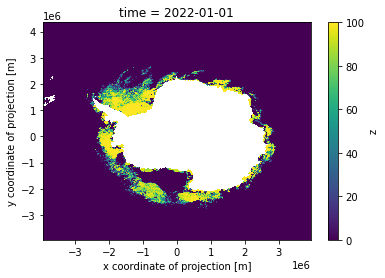

In [45]:
combined.isel(time=0).z.plot()

/g/data/jk72/MIZ/Bremen/netcdf/asi-AMSR2-s6250-20220101-v5.4.nc


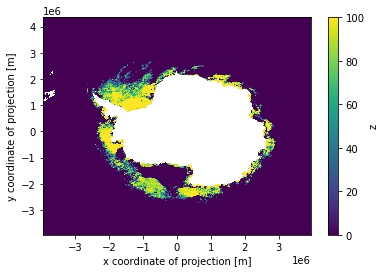

In [51]:
print(file_list[0])
xr.open_dataset(file_list[0]).z.plot()

In [ ]:
# resample daily to monthly

geotiffs_ds = geotiffs_ds.resample(time="M").mean()

In [15]:
# get monthly averages

monthly_average = geotiffs_ds.groupby('time.month').mean('time')

monthly_average = monthly_average.rename_dims({'month':'time'})

In [12]:
geotiffs_ds.to_netcdf(path='/g/data/jk72/MIZ/Bremen/netcdf/asi-AMSR2-s6250-2012-2022.nc')

In [3]:
test = xr.open_dataset('/g/data/jk72/sc0554/miz/processing/test.nc')

In [4]:
test

<xarray.Dataset>
Dimensions:                        (band: 1, y: 1328, x: 1264, time: 3565)
Coordinates:
  * band                           (band) int64 1
  * y                              (y) float64 4.347e+06 ... -3.947e+06
  * x                              (x) float64 -3.947e+06 ... 3.947e+06
  * time                           (time) datetime64[ns] 2012-07-02 ... 2022-...
Data variables:
    __xarray_dataarray_variable__  (time, band, y, x) uint8 ...

In [5]:
xr.open_dataset('/g/data/jk72/MIZ/Bremen/geotiff/asi-AMSR2-s6250-20120702-v5.4.tif', engine='rasterio')

<xarray.Dataset>
Dimensions:      (band: 1, x: 1264, y: 1328)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -3.947e+06 -3.941e+06 ... 3.941e+06 3.947e+06
  * y            (y) float64 4.347e+06 4.341e+06 ... -3.941e+06 -3.947e+06
    spatial_ref  int64 ...
Data variables:
    z            (band, y, x) float32 ...

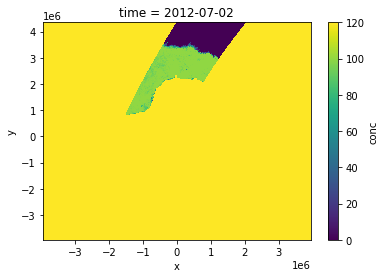

In [11]:
geotiffs_ds['conc'].isel(time=0).plot()

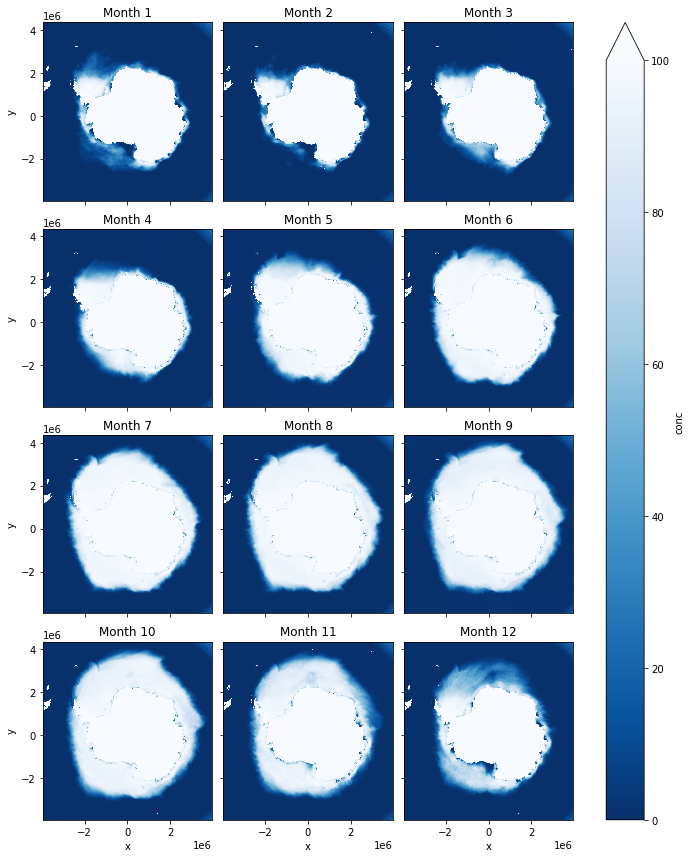

In [19]:
g = monthly_average['conc'].plot(col='time', col_wrap=3, cmap='Blues_r', vmin=0, vmax=100)

for i, ax in enumerate(g.axes.flat):

    ax.set_title(f"Month {i+1}")
    
plt.savefig('/g/data/jk72/sc0554/miz/bremen_monthly_average.png')

In [ ]:
plt.figure(figsize=(12,13))
plt.suptitle('Mean Sea Ice Concentration', fontsize=16)

for iMonth in np.arange(0, 12):
    
    ax = plt.subplot(4,4,iMonth+1,projection=ccrs.SouthPolarStereo())
    
    toPlot=monthly_average.sel(time=iMonth)
    
    plt.imshow(
        toPlot['conc'],
        #levels=[0,.15,.80,1.00],
#         levels=np.arange(0,1.04,.1),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='Blues_r',
        )

#     gl = ax.gridlines(
#         draw_labels=False, linewidth=2, color='gray', alpha=0.5, linestyle='--'
#     )

#     ax.coastlines()
    plt.title('Month ' + str(iMonth+1))
    
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.2,0.2,0.6,0.04]))
plt.show()

In [ ]:
geotiffs_ds_resample = geotiffs_ds.resample(time="M", keep_attrs=True).mean()
geotiffs_ds_resample.attrs = geotiffs_ds.attrs

In [ ]:
# Produce time series animation
xr_animation(ds=geotiffs_ds, 
             bands=['conc'],
             output_path='animated_timeseries.mp4',                                
             interval=100, 
             width_pixels=300,
             show_date='%b %Y')

# Plot animation
plt.close()
Video('animated_timeseries.mp4', embed=True)

### Bremen monthly data

In [2]:
filename = '/g/data/jk72/MIZ/Bremen/netcdf/asi-AMSR2-s6250-2012-2022.nc'
data = xr.open_dataset(filename)

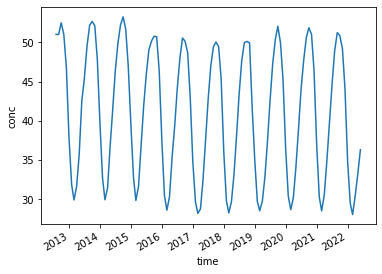

In [3]:
monthly_resample = data.resample(time="M").mean(keep_attrs=True)
# monthly_resample.attrs = data.attrs
monthly_resample['conc'].mean(dim=['x', 'y']).plot()

In [ ]:
plt.figure(figsize=(12,13))
plt.subplot(2)
plt.suptitle('Mean Sea Ice Concentration', fontsize=16)

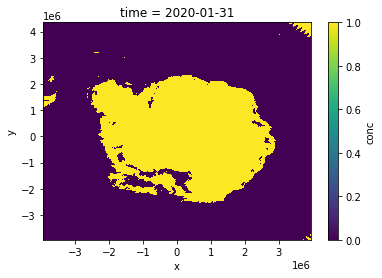

In [6]:
monthly_resample_threshold = monthly_resample['conc'] > 15

monthly_resample_threshold.sel(time='2020-01-31').plot()

In [14]:
def sea_ice_edging(da, threshold=15):
    # threshold data, default at 15%, converts data to boolean type
    # thresh = da > threshold
    # fill gaps in data
    filled = ndimage.binary_fill_holes(da)
    # canny filter for edge detection
    edge = feature.canny(filled)
    # fill small gaps in data with dilation
    edge = binary_dilation(edge, footprint=disk(2))
    return edge

In [15]:
monthly_edge = monthly_resample_threshold.groupby('time').apply(sea_ice_edging)

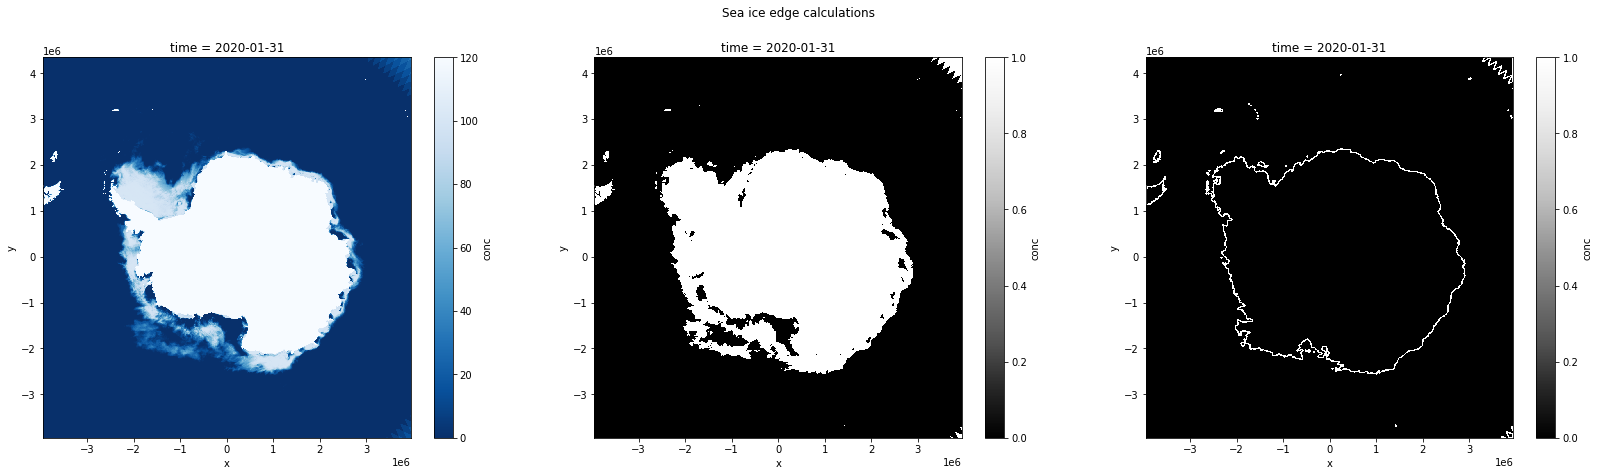

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('Sea ice edge calculations')
monthly_resample['conc'].sel(time='2020-01-31').plot(cmap='Blues_r', ax=ax1)
monthly_resample_threshold.sel(time='2020-01-31').plot(ax=ax2, cmap='Greys_r')
monthly_edge.sel(time='2020-01-31').plot(ax=ax3, cmap='Greys_r')
plt.savefig('/g/data/jk72/sc0554/miz/bremen_ice_edge_process.png')

In [ ]:
monthly_resample['conc'].sel(time='2020-01-31').rio.

In [63]:
# save out one year as netcdf for sample
monthly_edge.sel(time=slice('2020-01-01','2020-12-31')).to_netcdf(path='/g/data/jk72/sc0554/miz/monthly_sea_ice_edge_AMSR2-2020.nc')

(-0.5, 1263.5, 1327.5, -0.5)

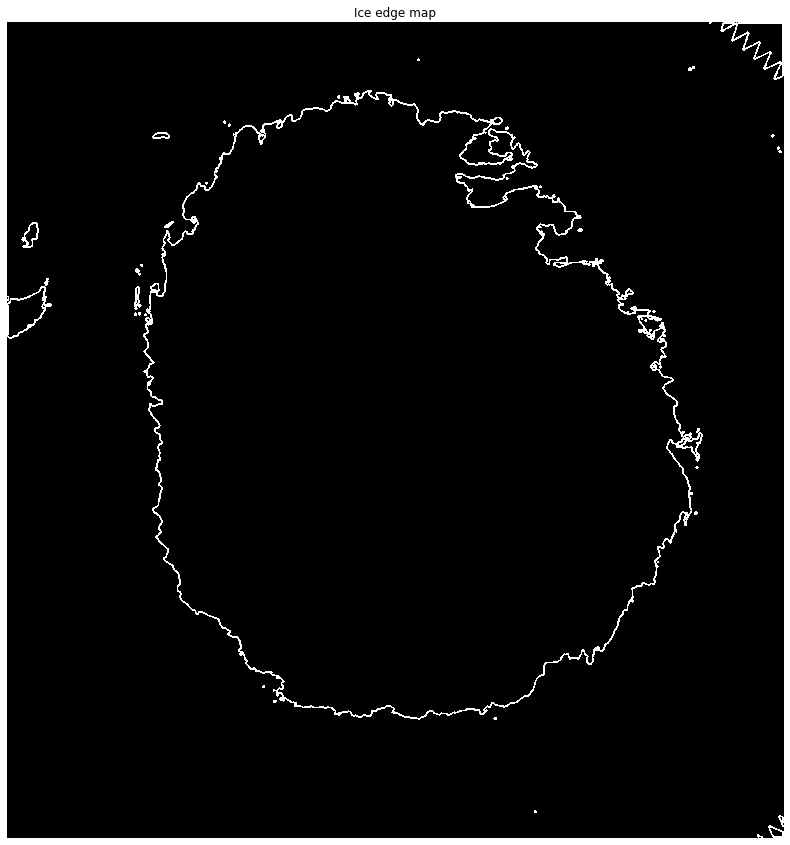

In [78]:
fig, ax = plt.subplots(figsize=(15,15))
cmp=ListedColormap(['black','white'])
ax.imshow(monthly_edge.isel(time=41), cmap=cmp)
ax.set_title('Ice edge map')
ax.axis('off')
# plt.savefig("/g/data/jk72/sc0554/miz/ice_edge_sample.png")

In [51]:
monthly_edge.to_netcdf(path='/g/data/jk72/sc0554/miz/monthly_sea_ice_edge_AMSR2-2012-2022.nc')

In [133]:
monthly_resample_threshold['values'] = (['time','y','x'],lines)
monthly_resample_threshold.to_dataset(name='conc')
# Produce time series animation
xr_animation(ds=monthly_resample_threshold, 
             bands=['conc'],
             output_path='animated_timeseries.mp4',                                
             interval=100, 
             width_pixels=300,
             show_date='%b %Y')

# Plot animation
plt.close()
Video('animated_timeseries.mp4', embed=True)

NameError: name 'xr_animation' is not defined

In [ ]:
monthly_resample.sel(time='2021-09-30')['conc'].rio.to_raster("/g/data/jk72/sc0554/miz/2021_month_avg.tif")